All of the data and metadata for the Allen Mouse Brain Atlas is now stored in a public bucket in Amazon's S3 data storage service. The utilities demonstrated here access that bucket through AWS's `boto3` API. In order to access the bucket, you will need an AWS account with credentials stored in a csv file that looks like
```
column1,Access key ID,Secret access key,column4,column5...
data1,your_access_key_id,your_secret_access_key,data4,data5,...
```
The full contnents of the file do not actually matter. All that matters is that there is a column named `Access key ID` and a column named `Secret access key`. The utilities in this module will extract those credentials an duse them to create a `boto3.Session` which will handle all transactions with S3.

We create that `Session` below, using the credentials in the file `accessKeys.csv`. This file is not a part of the repo you have cloned. It is a part of the developer's local system. You must provide your own equivalent of `accessKeys.csv` and alter the code below accordingly.

In [1]:
import os
credential_filename = 'accessKeys.csv'
assert os.path.isfile(credential_filename)

import aws_utils
boto3_session = aws_utils.get_boto3_session(credential_filename)
import json

Now that we have a `boto3.Session`, we will download the metadata for the Allen Mouse Brain Atlas. First, let's import the module containing the utilities for accessing the atlas.

In [2]:
import aba_mouse_utils as mouse_utils

Now let's download the metadata for the entire atlas. The method below downloads the file into a directory `tmp/` which is a subdirectory of this repository. If you want to use a different temporary directory, you can set it with the `tmp_dir` kwarg in that method (and all of the methods below that download data from S3). In addition to downloading the metadata, the method below will also load it into memory, giving you access to a list of dicts, each of which represents one "section data set" in the Allen Mouse Brain Atlas.

In [3]:
atlas_metadata = mouse_utils.get_atlas_metadata(session=boto3_session)

Consider just the first two elements in `atlas_metadata`

In [4]:
atlas_metadata[:2]

[{'id': 3,
  'genes': [{'acronym': 'Snap47', 'entrez_id': 67826}],
  'probes': [{'name': 'RP_040324_01_E07',
    'orientation': {'name': 'Antisense'}}],
  'plane_of_section': {'name': 'coronal'},
  'section_metadata': 'section_data_set_3/section_data_set.json'},
 {'id': 5,
  'genes': [{'acronym': 'Nvl', 'entrez_id': 67459}],
  'probes': [{'name': 'RP_Baylor_253948',
    'orientation': {'name': 'Antisense'}}],
  'plane_of_section': {'name': 'coronal'},
  'section_metadata': 'section_data_set_5/section_data_set.json'}]

Here we can see the very high level metadata about each of the section data sets in the atlas. To download the detailed metadata about one of these sets, we use the class `SectionDatSet`, which we instantiate with the `id` of the section data set found in the atlas metadata above.

In [5]:
section_data = mouse_utils.SectionDataSet(5, session=boto3_session)

`section_data.metadata` is now a dict containing all of the metadata about the section data set.

In [6]:
key_list = list(section_data.metadata.keys())
key_list.sort()
print(key_list)

['genes', 'id', 'plane_of_section', 'probes', 'section_thickness', 'specimen', 'treatments']


In [7]:
print(json.dumps(section_data.metadata, indent=2, sort_keys=True))

{
  "genes": [
    {
      "acronym": "Nvl",
      "entrez_id": 67459
    }
  ],
  "id": 5,
  "plane_of_section": {
    "name": "coronal"
  },
  "probes": [
    {
      "gi": 33468980,
      "name": "RP_Baylor_253948",
      "ncbi_accession_number": "NM_026171.1",
      "orientation": {
        "name": "Antisense"
      },
      "predicted_sequence": {
        "id": 508423,
        "sequence_data": "CCTGTTCGCAACCCAGACCAGTTCAGAACTCTTGGTTTGGGGACTCCAGCTGGCATCCTCCTAGCTGGTCCTCCTGGGTGTGGAAAAACTCTGCTAGCAAAGGCTGTGGCAAATGAGTCTGGACTAAATTTTATATCTGTCAAAGGCCCTGAATTATTGAATATGTATGTTGGTGAGAGTGAACGTGCTGTTCGACAAGTTTTTCAGCGAGCCAAGAACTCAGCCCCCTGCGTGATATTTTTTGATGAAGTGGATGCTTTATGTCCTCGGAGATCAGACCGAGAAACAGGTGCTAGTGTTCGTGTGGTGAATCAGCTGCTTACAGAGATGGATGGCTTAGAAACACGCCAGCAAGTTTTTATTTTGGCTGCCACCAATAGACCAGATATCATTGACCCTGCCATTCTGCGCCCAGGCCGCCTGGACAAAACGCTCTTTGTGGGTTTGCCTCCCCCAGCAGACCGTGTTGCCATATTAAAGACTATTACAAAAAATGGCACCAAACCTCCACTGGATGAAGATGTAAATTTGGAAACAATTGCTAATGACCTTCGTTGTAATTGCTATACGGGTGCGGACCTCACTGCTCTGGTACGG

Metadata about the images that make up this section dataset can be accessed according to either their `sub_image_id` or their `tissue_index`. Below, we show lists of valid values for these parameters.

In [8]:
print(section_data.tissue_indices)
print('')
print(section_data.sub_image_ids)

[2, 10, 18, 26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146, 154, 162, 170, 178, 186, 194, 202, 258, 266, 274, 282, 290, 298, 306, 314, 330, 370, 378, 386, 394, 402, 410, 418, 426, 434, 442]

[101323412, 101323418, 101323424, 101323430, 101323436, 101323442, 101323448, 101323454, 101323460, 101323466, 101323472, 101323478, 101323484, 101323490, 101323496, 101323502, 101323508, 101323514, 101323520, 101323526, 101323532, 101323538, 101323544, 101323550, 101323556, 101323562, 101323598, 101323604, 101323610, 101323616, 101323622, 101323628, 101323634, 101323640, 101323651, 101323677, 101323683, 101323689, 101323695, 101323701, 101323707, 101323713, 101323719, 101323725, 101323731]


To get the metadata associated with one of these images, use

In [9]:
image_metadata = section_data.image_metadata_from_tissue_index(58)

In [10]:
print(image_metadata['id'])

101323454


In [11]:
alt_metadata = section_data.image_metadata_from_sub_image(image_metadata['id'])
assert alt_metadata == image_metadata

In [12]:
print(image_metadata.keys())

dict_keys(['bits_per_component', 'id', 'resolution', 'section_number', 'downsampling', 'image_file_name'])


All of the images in the atlas exist at multiple resolutions. Each resolution is identified by a downsampling tier. `downsampling == 0` corresponds to the full resolution image. Each larger downsampling tier corresponds to a factor of 2 reduction in resolution in both the x and y direction, so `downsampling == 1` is a factor of 4 smaller than `downsampling == 0`; `downsampling == 2` is a factor of 16 smaller than `downsampling == 0`; etc.

To see what downsampling tiers are available for each image, use

In [13]:
downsampling_tiers = list(image_metadata['downsampling'].keys())
downsampling_tiers.sort()
print(downsampling_tiers)

['downsample_0', 'downsample_1', 'downsample_2', 'downsample_3', 'downsample_4', 'downsample_5']


**Note:** in some rare cases, the full-resolution image file became corrupted during processing and was lost. These will correspond to images that have a valid `downsample_1` but no `downsample_0`. If you ever ask for a downsampling index that does not exist, the code should fail gracefully and issue a warning.

The methods `SectionDataSet.download_image_from_tissue_index` and `SectionDataSet.download_image_from_sub_image` allow you to download an image as a TIFF file, specifying it by either its tissue index or its sub-image ID and its downsampling index.

Let's download the `downsampling == 3` copy of the image with `tissue_index == 58`. We must specify a local filename in which to write the image.

These methods return `True` if the image was downloaded; `False` otherwise.

In [14]:
local_filename = 'example_aba_image.tiff'
section_data.download_image_from_tissue_index(58, 3, local_filename)

True

Let's visualize the image with matplotlib.

In [15]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import PIL.Image

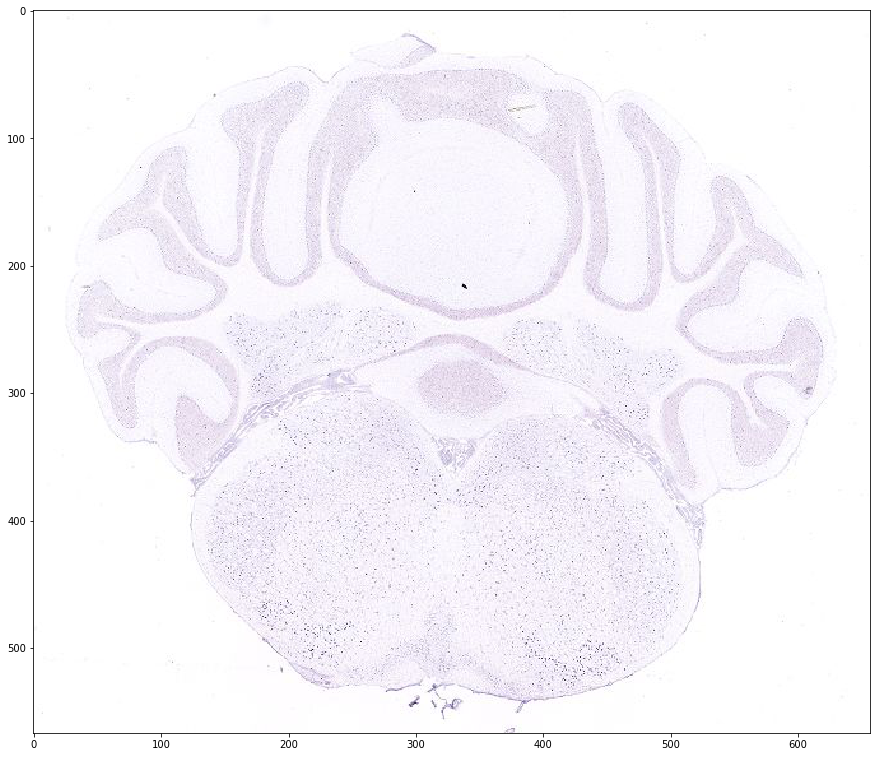

In [16]:
plt.figure(figsize=(15,15))
img = PIL.Image.open(local_filename)
plt.imshow(img)

Let's backup and take a closer look at the metadata associated with this image.

In [17]:
print(json.dumps(image_metadata, indent=2, sort_keys=True))

{
  "bits_per_component": 8,
  "downsampling": {
    "downsample_0": {
      "height": 4536,
      "image_file_height": 4536,
      "image_file_width": 5256,
      "width": 5256,
      "x": 0,
      "y": 0
    },
    "downsample_1": {
      "height": 2268,
      "image_file_height": 2268,
      "image_file_width": 2628,
      "width": 2628,
      "x": 0,
      "y": 0
    },
    "downsample_2": {
      "height": 1134,
      "image_file_height": 1134,
      "image_file_width": 1314,
      "width": 1314,
      "x": 0,
      "y": 0
    },
    "downsample_3": {
      "height": 567,
      "image_file_height": 567,
      "image_file_width": 657,
      "width": 657,
      "x": 0,
      "y": 0
    },
    "downsample_4": {
      "height": 283,
      "image_file_height": 283,
      "image_file_width": 328,
      "width": 328,
      "x": 0,
      "y": 0
    },
    "downsample_5": {
      "height": 141,
      "image_file_height": 141,
      "image_file_width": 164,
      "width": 164,
      "x": 0,

Each downsampling tier lists a `height`, a `width`, an `x` coordinate, and a `y` coordinate. `x` and `y` denote the upper left corner of the image. Naively, `height` and `width` denote the height and width of the TIFF file itself (that is why, in this case, they are identical to `image_file_height` and `image_file_width`). In some cases, however, one TIFF file can contain multiple images of tissues, in which case these parameters will denote the origin and bounds of individual sub images. For example:

In [18]:
dataset = mouse_utils.SectionDataSet(100055044, session=boto3_session)
subimage_5 = dataset.image_metadata_from_tissue_index(5)
subimage_13 = dataset.image_metadata_from_tissue_index(13)
assert subimage_5['image_file_name'] == subimage_13['image_file_name']

In [19]:
print(json.dumps(subimage_5, indent=2, sort_keys=True))

{
  "bits_per_component": 8,
  "downsampling": {
    "downsample_0": {
      "height": 6384,
      "image_file_height": 38208,
      "image_file_width": 19136,
      "width": 9072,
      "x": 5120,
      "y": 30368
    },
    "downsample_1": {
      "height": 3192,
      "image_file_height": 19104,
      "image_file_width": 9568,
      "width": 4536,
      "x": 2560,
      "y": 15184
    },
    "downsample_2": {
      "height": 1596,
      "image_file_height": 9552,
      "image_file_width": 4784,
      "width": 2268,
      "x": 1280,
      "y": 7592
    },
    "downsample_3": {
      "height": 798,
      "image_file_height": 4776,
      "image_file_width": 2392,
      "width": 1134,
      "x": 640,
      "y": 3796
    },
    "downsample_4": {
      "height": 399,
      "image_file_height": 2388,
      "image_file_width": 1196,
      "width": 567,
      "x": 320,
      "y": 1898
    },
    "downsample_5": {
      "height": 199,
      "image_file_height": 1194,
      "image_file_width":

In [20]:
print(json.dumps(subimage_13, indent=2, sort_keys=True))

{
  "bits_per_component": 8,
  "downsampling": {
    "downsample_0": {
      "height": 7232,
      "image_file_height": 38208,
      "image_file_width": 19136,
      "width": 9504,
      "x": 4448,
      "y": 20560
    },
    "downsample_1": {
      "height": 3616,
      "image_file_height": 19104,
      "image_file_width": 9568,
      "width": 4752,
      "x": 2224,
      "y": 10280
    },
    "downsample_2": {
      "height": 1808,
      "image_file_height": 9552,
      "image_file_width": 4784,
      "width": 2376,
      "x": 1112,
      "y": 5140
    },
    "downsample_3": {
      "height": 904,
      "image_file_height": 4776,
      "image_file_width": 2392,
      "width": 1188,
      "x": 556,
      "y": 2570
    },
    "downsample_4": {
      "height": 452,
      "image_file_height": 2388,
      "image_file_width": 1196,
      "width": 594,
      "x": 278,
      "y": 1285
    },
    "downsample_5": {
      "height": 226,
      "image_file_height": 1194,
      "image_file_width":

Note that the two sub-images share the same `image_file_name`, indicating that they are subsections of the same TIFF file. Similarly, for each downsampling tier, they share the same `image_file_height` and `image_file_width`, representing the total number of pixels in the TIFF file, but they have different `height`, `width`, `x`, and `y`, representing the different bounding boxes of the different sub-images.

In [21]:
for ds in subimage_5['downsampling'].keys():
    assert subimage_5['downsampling'][ds]['image_file_height'] == subimage_13['downsampling'][ds]['image_file_height']
    assert subimage_5['downsampling'][ds]['image_file_width'] == subimage_13['downsampling'][ds]['image_file_width']

The utilities to download a TIFF image are aware of the possibility that a single file contains multiple brain section images. They automatically crop the TIFF in AWS to contain only the selected brain slice image. The TIFF that is actually saved on your local machine represents only the region of the image described by `x`, `y`, `width` and `height`.

In [22]:
local_filename = 'example_compound_image.tiff'
dataset.download_image_from_tissue_index(13, 5, local_filename)

True

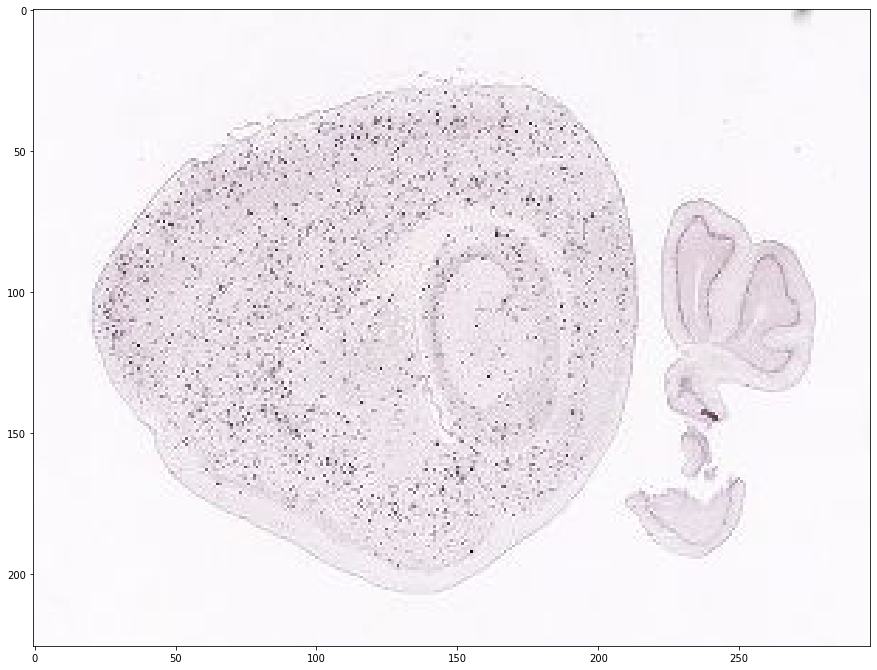

In [23]:
plt.figure(figsize=(15,15))
img = PIL.Image.open(local_filename)
plt.imshow(img)